#PROYECTO N°2 DE RNA - CARLOS DOFFINY S-V
Detección de Objetos con Faster R-CNN y Detectron2

#Información DataSet

El data set (de autoría propia) está conformado por las siguientes 5 clases:


*   Airplane (30 imágenes)
*   Car (30 imágenes)
*   Cat (30 imágenes)
*   Penguin (30 imágenes)
*   Tank (30 imágenes)

Esto daría un total de 150 imágenes (todas con un tamaño de 416x416 pixeles), cuyos objetos fueron detectados y sus cajas indicadas con la ayuda de [LabelImg](https://github.com/tzutalin/labelImg), que se dividirán en los siguientes grupos de datos:


*   Datos de entrenamiento (70% - 105 imágenes)
*   Datos de validación (20% - 30 imágenes)
*   Datos de prueba (10% - 15 imágenes)

Sin embargo, al tratarse de un data set pequeño, y con la idea de evitar el sobre entrenamiento del mismo, se decidió ejecutar un augmentation de 3x a los datos de entrenamiento con imágenes volteadas horizontalmente, con zoom de 20%, un brillo de +- 25 grados, y una rotación horizontal de +- 6 grados, agregando así unas 210 imágenes a la data de entrenamiento, que darían un total de:

*   Datos de entrenamiento (88% - 315 imágenes)
*   Datos de validación (8% - 30 imágenes)
*   Datos de prueba (4% - 15 imágenes)

**Total de imágenes del data set:** 360 imágenes.

El data set se puede encontrar dando click al siguiente link: [Data set Proyecto 2 RNA de Carlos Doffiny S-V](https://app.roboflow.com/carlos-doffiny-s-v/proyecto2_rna_carlos_doffiny_sv/1)





#Información adicional
Antes de comenzar, me gustaría agradecer al Framework de [Roboflow](https://roboflow.com/), que me ayudó muchísimo para la creación y carga del data set, con el preprocesamiento de cada una de las imágenes, con el augmentation de la data de entrenamiento, y sobre todo, con la guía y el modelo ofrecido para la creación de la presente red neuronal de detección de objetos.

De guía utilicé el siguiente vídeo: [How to Train a Custom Faster R-CNN Model with Facebook AI's Detectron2 | Use Your Own Dataset](https://www.youtube.com/watch?v=4OXntFVfFio)

#Verificamos el uso de una GPU

In [1]:
!nvidia-smi #La idea es que imprima que se está usando la GPU Tesla K80

Tue Apr 19 13:10:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Imports

##Dependencias necesarias para Detectron2

In [2]:
#Se usa cu101 ya que colab trabaja con CUDA 10.1
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html #Instalando Pytorch
!pip install cython pyyaml==5.1 #InstalandoLibrería para el manejo de pyyaml
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' #Descargando la API de COCO (dataset de imágenes)
import torch, torchvision #Import torch
print(torch.__version__, torch.cuda.is_available()) #Imprime la versión y true de CUDA si es que se está usando la GPU efectivamente
!gcc --version #Imprime la versión del compilador GNU que se está usando

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 23 kB/s 
     |████████████████████████████████| 6.6 MB 46.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 12.6 MB/s 
  Created wheel f

##Descargar e Instalar Detectron2
A veces no se descarga a la primera, y hay que ejecutarlo varias veces hasta que encuentre la versión indicada y la descargue

In [5]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html #Descarga e instalación de Detectron2

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 838 kB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220414-py3-none-any.whl size=61211 sha256=b392e0d64cc0dae663e70064460041d6868deaf6cdd7fe80c124b41b8447ec74
  Stored in directory: /root/.cache/pip/wheels/df/f4/b8/7b5df8b6722f4c72315ce70c31aa693e00cef6a5056149bd28
Successfully built fvcore


##Dependencias de las demás librerías

In [6]:
# Configuración del logger de detectron 2
import detectron2 #Importar la librería detectron2
from detectron2.utils.logger import setup_logger #De detectron2 importar la configuración del logger
setup_logger() #Configurar el logger

#Importación de librerías usadas con anterioridad
import numpy as np #Para los diferentes vectores y matrices que se usarán
import cv2 #Import para leer imágenes agregadas en archivos
import random #Para los randoms o números aleatorios
from google.colab.patches import cv2_imshow #Para mostrar las imágenes con sus cajas de detección de objetos
import matplotlib.pyplot as plt #Para graficar
import glob #Para trabajar con los paths de archivos y carpetas

#Importaciones de herramientas muy útiles de detectron2
from detectron2 import model_zoo #Para los modelos y diferentes arquitecturas que se pueden usar
from detectron2.engine import DefaultPredictor #Predictor del motor de entrenamiento de detectron2
from detectron2.config import get_cfg #Para los config de los diferentes modelos
from detectron2.utils.visualizer import Visualizer #Para dibujar la data visualizada y detectada con su respectiva caja y label
from detectron2.data import MetadataCatalog #Diccionario global que permite acceder a los metadatos del dataset a utilizar
from detectron2.data.catalog import DatasetCatalog #Diccionario global que contiene información sobre cómo trabajar con los datasets
from detectron2.data.datasets import register_coco_instances #Para trabajar con el formato de archivo de los jsons de COCO
from detectron2.engine import DefaultTrainer #Motor para el entrenamiento del dataset
from detectron2.evaluation import COCOEvaluator #Para la evaluación de la detección de Objetos
from detectron2.utils.visualizer import ColorMode #Para los colores de las imágenes de las predicciones
from detectron2.data import build_detection_test_loader #Para trabajar con los datasets y sus pruebas
from detectron2.evaluation import inference_on_dataset #Para evaluar el modelo con sus checkpoints

#Importar y descargar el Dataset 
Este dataset, que como ya sabemos está alojado en Roboflow, ya vendrá con un resize de todas las 360 imágenes (las 150 originales y las 210 generadas con augmentation) con un tamaño de 416x416 pixeles


In [7]:
!curl -L "https://app.roboflow.com/ds/qhPi1WEqSJ?key=DFrmabzck8" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip #Esto descargará el .zip y lo descomprimirá en los archivos de este colab.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1581      0 --:--:-- --:--:-- --:--:--  1581
100 7124k  100 7124k    0     0  3148k      0  0:00:02  0:00:02 --:--:-- 7785k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/10_jpg.rf.4dd10c0e8b6b97ab58430475bda760be.jpg  
 extracting: test/10_jpg.rf.985fbf5cf9efb31c235a0a2fe37cbfe7.jpg  
 extracting: test/10_jpg.rf.b0ca661d2c23a32455bb557d9fb27919.jpg  
 extracting: test/13_jpg.rf.722852a89da5965b1566054d763e0a7f.jpg  
 extracting: test/13_jpg.rf.92393a09af5544f0a414b1ee5a2eb15f.jpg  
 extracting: test/15_jpg.rf.770a28204ccd8c0697b9ccf278af1d9e.jpg  
 extracting: test/1_jpg.rf.7139f946d0be10649aa6ba156c646679.jpg  
 extracting: test/1_jpg.rf.8466f1b1623c4e7cb52d96242a1df6e6.jpg  
 extracting: test/1_jpg.rf.f2621

##Identificación de los diferentes grupos de datos de imágenes
Estos ya fueron debidamente clasificados y separados en Roboflow en los 3 grupos deseados:


*   Entrenamiento (88% - 315 imágenes)
*   Validación (8% - 30 imágenes)
*   Prueba (4% - 15 imágenes)

In [8]:
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train") #Datos o imágenes de entrenamiento
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid") #Datos o imágenes de validación
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test") #Datos o imágenes de prueba

#Visualización de las imágenes de entrenamiento
Con la finalidad de comprobar que la descarga de las imágenes se hizo sin problema alguno y que su etiquetado funciona correctamente

WARNING [04/19 16:05:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/19 16:05:23 d2.data.datasets.coco]: Loaded 315 images in COCO format from /content/train/_annotations.coco.json


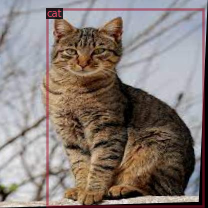

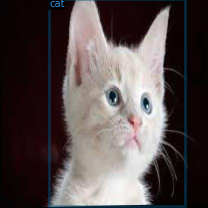

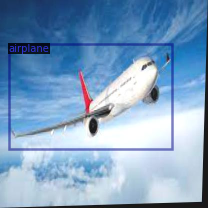

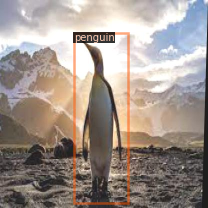

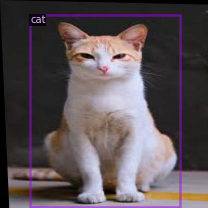

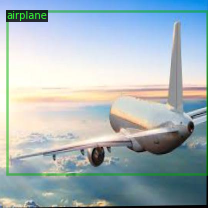

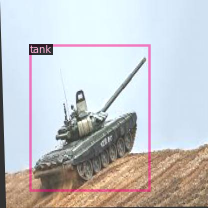

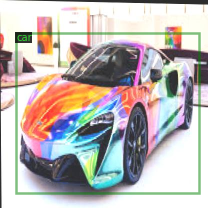

In [44]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train") #Accediendo a la metadata de entrenamiento para obtener así los labels, posiciones de la caja, colores, etc
dataset_dicts = DatasetCatalog.get("my_dataset_train") #Accediendo al dataset de entrenamiento

for d in random.sample(dataset_dicts, 8): #Para 5 imágenes random seleccionadas del dataset de entrenamiento 
    img = cv2.imread(d["file_name"]) #Obtiene la imagen
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5) #Para visualizar la imagen con su respectivo label y caja
    vis = visualizer.draw_dataset_dict(d) #Dibuja las anotaciones o cajitas de la imagen
    cv2_imshow(vis.get_image()[:, :, ::-1]) #Imprimir la imagen

#Entrenamiento del data set con Detectron2

##Configurar los directorios a usar durante el entrenamiento

In [10]:
#Aquí importamos el módulo de entrenamiento que usará la validación y evaluación de COCO durante el entrenamiento

class CocoTrainer(DefaultTrainer):

#Función encargada de crear y configurar los directorios en donde se almacenarán los resultados de los entrenamientos
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None): 

    if output_folder is None: #En caso de que no exista una carpeta de salida para los resultados
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval" #Carpeta en donde se almacenarán los resultados

    return COCOEvaluator(dataset_name, cfg, False, output_folder) #Retorna el evaluador del COCO

##Configurar los parámetros del entrenamiento y entrenar

In [11]:
#La arquitectura Faster R-CNN v101 COCO la seleccionamos del siguiente link:
# https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg #Obtiene una copia del config que viene por default
import os #Para interactuar con el sistema operativo que está usando este colab

cfg = get_cfg() #Obtener las configuraciones que trae por defecto
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")) #De model zoo traerse la arquitectura Faster R-CNN v101 COCO
cfg.DATASETS.TRAIN = ("my_dataset_train",) #Indicar el dataset de entrenamiento
cfg.DATASETS.TEST = ("my_dataset_val",) #Indicar el dataset de validación


cfg.DATALOADER.NUM_WORKERS = 4 #Número de subprocesos de carga de datos
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  #Para que el entrenamiento se inicie con los pesos que ya contiene esta arquitectura Faster R-CNN v101 COCO con sus entrenamientos previos
cfg.SOLVER.IMS_PER_BATCH = 4 #Número de imágenes por lote
cfg.SOLVER.BASE_LR = 0.001 #Parámetro de aprendizaje 


cfg.SOLVER.WARMUP_ITERS = 1000 #Iteración desde la cual empezará a disminuir la tasa de aprendizaje de gamma
cfg.SOLVER.MAX_ITER = 1500 #Número de Épocas
cfg.SOLVER.STEPS = (1000, 1500) #El rango entre los dos valores anteriores
cfg.SOLVER.GAMMA = 0.05 #Gamma


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64 #Regiones de interés por imágen
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 #Número de clases + 1

cfg.TEST.EVAL_PERIOD = 500 #Épocas de validación durante el entrenamiento


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) #Crear el directorio de entrenamiento
trainer = CocoTrainer(cfg) #Crear el modelo de entreamiento con las configuraciones que acabámos de ingresar
trainer.resume_or_load(resume=False) #Para empezar el entrenamiento desde 0
trainer.train() #Ejecutar el entrenamiento

[04/19 13:16:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:18, 23.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[04/19 13:16:39 d2.engine.train_loop]: Starting training from iteration 0
[04/19 13:18:22 d2.utils.events]:  eta: 2:03:48  iter: 19  total_loss: 2.798  loss_cls: 1.905  loss_box_reg: 0.882  loss_rpn_cls: 0.002  loss_rpn_loc: 0.005  time: 5.1545  data_time: 0.0354  lr: 0.000020  max_mem: 7210M
[04/19 13:20:08 d2.utils.events]:  eta: 2:12:17  iter: 39  total_loss: 2.405  loss_cls: 1.486  loss_box_reg: 0.896  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  time: 5.2340  data_time: 0.0150  lr: 0.000040  max_mem: 7210M
[04/19 13:21:50 d2.utils.events]:  eta: 2:09:55  iter: 59  total_loss: 1.757  loss_cls: 0.900  loss_box_reg: 0.854  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 5.1817  data_time: 0.0187  lr: 0.000060  max_mem: 7210M
[04/19 13:23:34 d2.utils.events]:  eta: 2:08:15  iter: 79  total_loss: 1.514  loss_cls: 0.642  loss_box_reg: 0.857  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  time: 5.1896  data_time: 0.0156  lr: 0.000080  max_mem: 7210M
[04/19 13:25:18 d2.utils.events]:  eta: 2:06:3

#Evaluación del modelo

In [13]:
#test evaluation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") #Actualizando los pesos obtenidos al final del entrenamiento
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85 #Indicando el umbral de rechazo
predictor = DefaultPredictor(cfg) #Predecir el modelo
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/") #Evaluación del modelo
val_loader = build_detection_test_loader(cfg, "my_dataset_test") #Crear el loader de testeo
inference_on_dataset(trainer.model, val_loader, evaluator) #Inferencia del modelo por si queremos usarlo en otras aplicaciones

WARNING [04/19 15:27:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/19 15:27:14 d2.data.datasets.coco]: Loaded 15 images in COCO format from /content/test/_annotations.coco.json
[04/19 15:27:14 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  Objects   | 0            |  airplane  | 4            |    car     | 1            |
|    cat     | 3            |  penguin   | 2            |    tank    | 5            |
|            |              |            |              |            |              |
|   total    | 15           |            |              |            |              |
[04/19 15:27:14 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[04/19 15:27:14 d2.data.common]: Serialized da

OrderedDict([('bbox',
              {'AP': 75.84422442244224,
               'AP-Objects': nan,
               'AP-airplane': 88.81188118811882,
               'AP-car': 99.99999999999997,
               'AP-cat': 28.84488448844884,
               'AP-penguin': 90.0,
               'AP-tank': 71.56435643564356,
               'AP50': 91.0891089108911,
               'AP75': 75.07590759075907,
               'APl': 75.84422442244224,
               'APm': nan,
               'APs': nan})])

##Actualizar los pesos con los resultantes de la última iteración del entrenamiento

In [14]:
%ls ./output/ #Se muestran los archivos existentes en la carpeta output

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") #Actualizar los pesos de la red con los últimos obtenidos durante el entrenamiento

coco_instances_results.json                       last_checkpoint
events.out.tfevents.1650374180.a0fe2e911a0f.71.0  metrics.json
instances_predictions.pth                         model_final.pth


#Predicción del modelo
Usando los datos de prueba, conformados por 15 imágenes que representan el 4% del data set

In [15]:
cfg.DATASETS.TEST = ("my_dataset_test", ) #Indicar la data de prueba
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   #Umbral de rechazo o de prueba
predictor = DefaultPredictor(cfg) #Predecir el modelo
test_metadata = MetadataCatalog.get("my_dataset_test") #Indicar los metadatos de la data de prueba

#Probar la red entrenada con la data de prueba

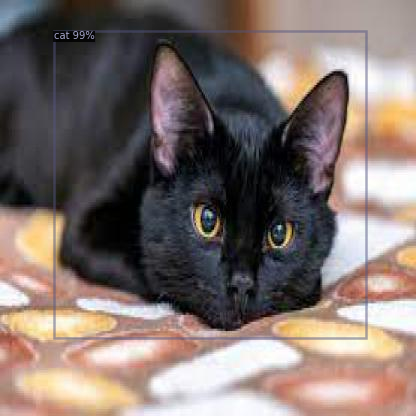

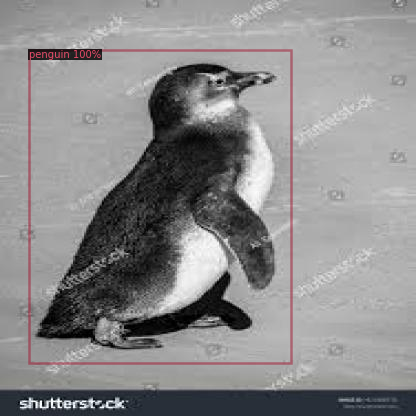

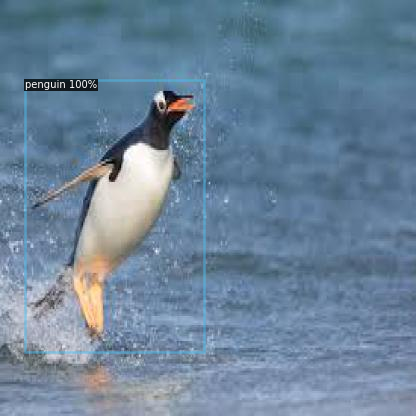

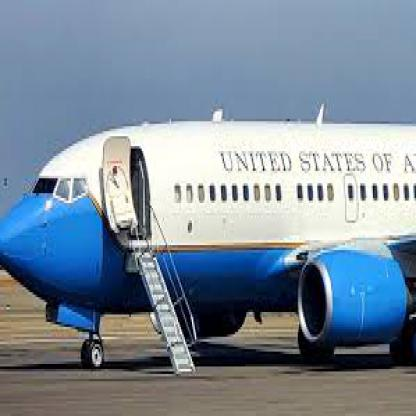

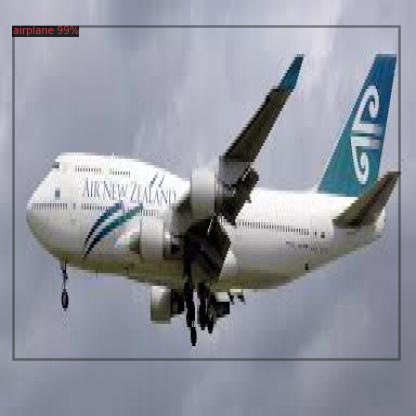

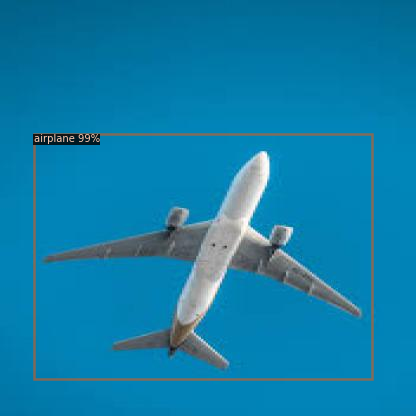

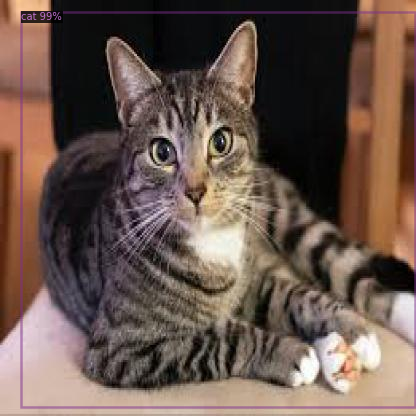

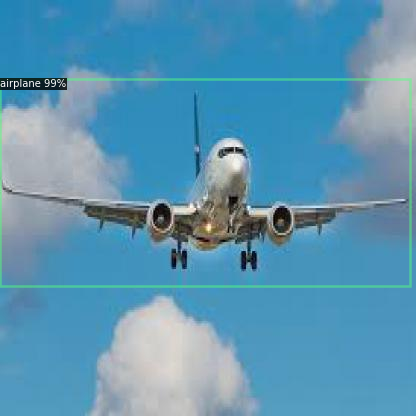

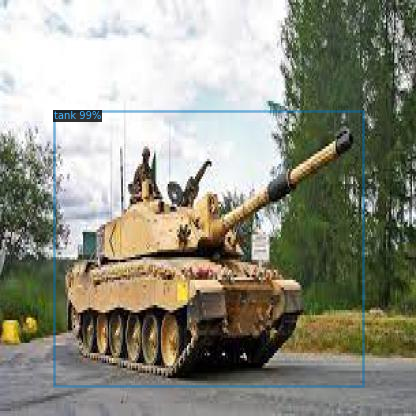

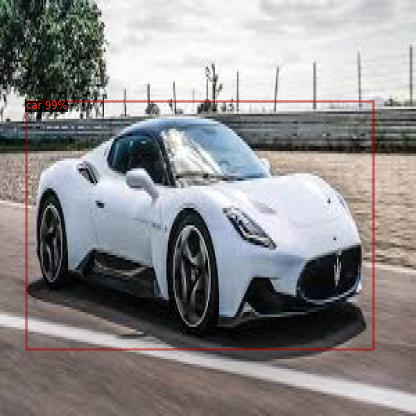

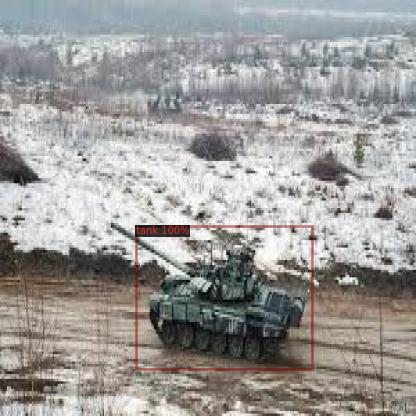

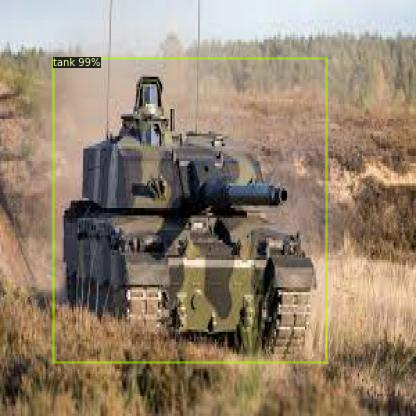

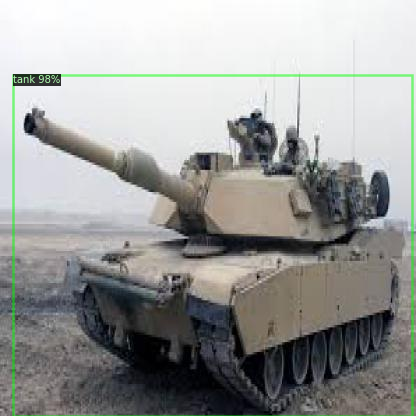

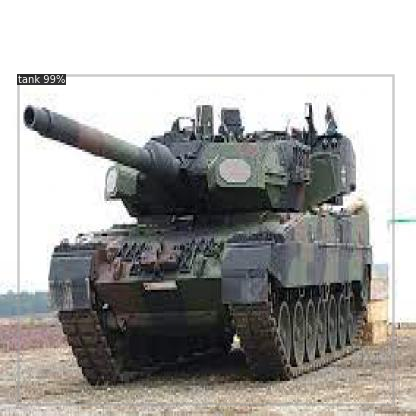

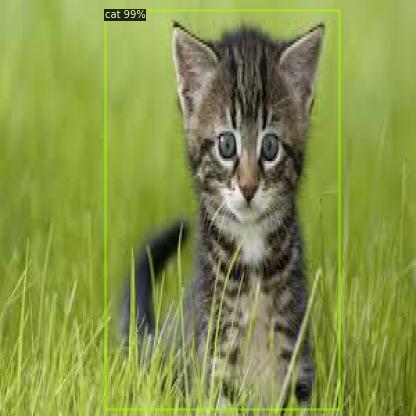

In [20]:
for imageName in glob.glob('/content/test/*jpg'): #Para cada imagen (su nombre) en el path indicado
  im = cv2.imread(imageName) #Obtener la imagen a partitr de su nombre
  outputs = predictor(im) #Predecir la imagen y detectar sus objetos
  v = Visualizer(im[:, :, ::-1], #Visualizar la imagen en una escala del 80% y con sus metadatos
                metadata=test_metadata, 
                scale=1
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Para dibujar las cajas y labels de los objetos detectados
  cv2_imshow(out.get_image()[:, :, ::-1]) #Imprimir y mostrar la imagen


#Probar la red con cualquier imagen 

##Leer y obtener la imagen

In [29]:
IMAGE_SHAPE= (416,416) #Indicando el tamaño que queremos para las imágenes

def readImage(im): #Función encargada de leer las imágenes provenientes de los archivos del colab
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #Como vienen en BGR hay que convertirlas a RGB
  plt.imshow(im) #Mostrando la imagen
  plt.axis(False) #Eliminando los ejes de coordenadas
  print('La imagen original es:\n')

##Predecir la imagen y detectar sus objetos

In [30]:
def predictImage(im): #Función encargada de predecir las imágenes
  outputs = predictor(im) #Predecir la imagen y detectar sus objetos
  v = Visualizer(im[:, :, ::-1], #Visualizar la imagen en una escala del 80% y con sus metadatos
    metadata=test_metadata, 
    scale=1
    )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Para dibujar las cajas y labels de los objetos detectados
  print('La predicción de la imagen es:\n')
  cv2_imshow(out.get_image()[:, :, ::-1])  #Imprimir y mostrar la imagen

##Ejemplos

###1: Combinación de objetos entrenados

La imagen original es:



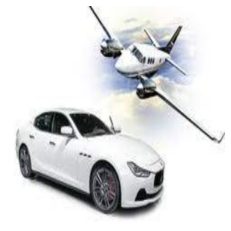

In [32]:
im = cv2.imread('car and airplane.jpg') #Lectura de la imagen
im2 = cv2.resize(im, IMAGE_SHAPE) #Resize de la imagen al tamaño deseado
readImage(im2) #Lectura de la imagen

La predicción de la imagen es:



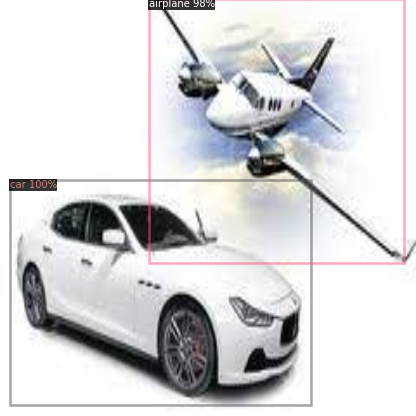

In [33]:
predictImage(im2) #Predicción de la imagen

###2: Objeto diferente a los entrenados

La imagen original es:



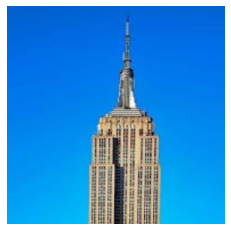

In [34]:
im = cv2.imread('empire.jpg') #Lectura de la imagen
im2 = cv2.resize(im, IMAGE_SHAPE) #Resize de la imagen al tamaño deseado
readImage(im2) #Lectura de la imagen

La predicción de la imagen es:



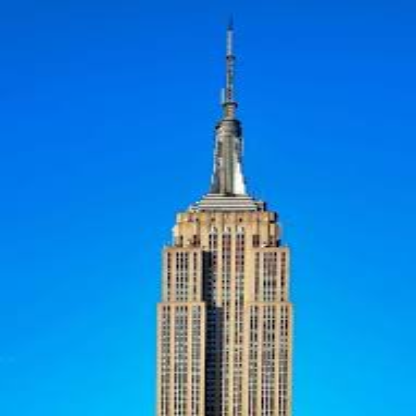

In [35]:
predictImage(im2) #Predicción de la imagen

###3: Objeto igual a los entrenados

La imagen original es:



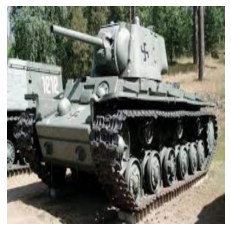

In [36]:
im = cv2.imread('tanque.jpg') #Lectura de la imagen
im2 = cv2.resize(im, IMAGE_SHAPE) #Resize de la imagen al tamaño deseado
readImage(im2) #Lectura de la imagen

La predicción de la imagen es:



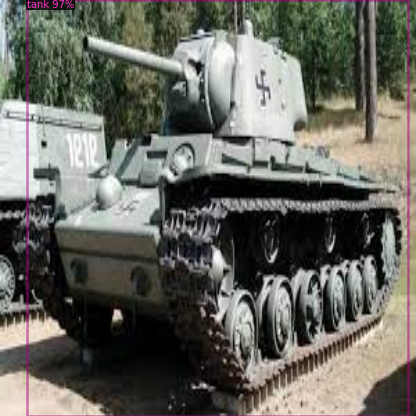

In [37]:
predictImage(im2) #Predicción de la imagen

La imagen original es:



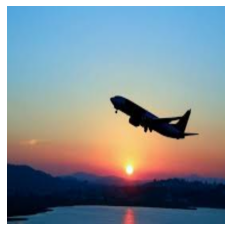

In [42]:
im = cv2.imread('airplane.jpg') #Lectura de la imagen
im2 = cv2.resize(im, IMAGE_SHAPE) #Resize de la imagen al tamaño deseado
readImage(im2) #Lectura de la imagen

La predicción de la imagen es:



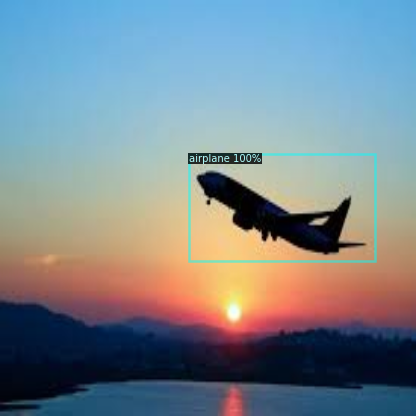

In [43]:
predictImage(im2) #Predicción de la imagen

###4: Múltiples objetos de los entrenados en la misma imagen

La imagen original es:



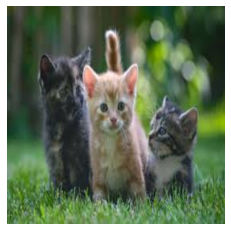

In [38]:
im = cv2.imread('cats.jpg') #Lectura de la imagen
im2 = cv2.resize(im, IMAGE_SHAPE) #Resize de la imagen al tamaño deseado
readImage(im2) #Lectura de la imagen

La predicción de la imagen es:



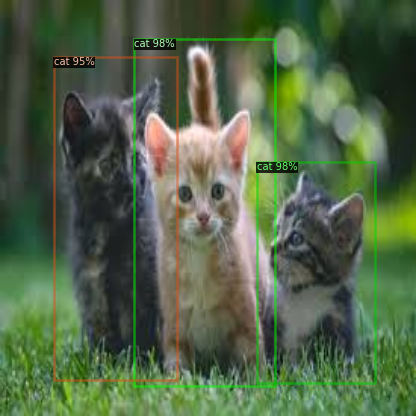

In [39]:
predictImage(im2) #Predicción de la imagen

###5: Imagen libre indicada por el profesor

In [ ]:
im = cv2.imread('.jpg') #Lectura de la imagen
im2 = cv2.resize(im, IMAGE_SHAPE) #Resize de la imagen al tamaño deseado
readImage(im2) #Lectura de la imagen

In [ ]:
predictImage(im2) #Predicción de la imagen